In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-04-01 14:59:01--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.197.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   213MB/s    in 0.3s    

2022-04-01 14:59:01 (213 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
import os
import shutil

if os.path.exists('/content/cats_and_dogs_filtered/'):
  shutil.rmtree('/content/cats_and_dogs_filtered/')
  print('/content/cats_and_dogs_filtered/ is removed!!!')

In [5]:
import zipfile

with zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r') as target_file:
  target_file.extractall('/content/cats_and_dogs_filtered/')

ImageDataGenerator 불러오기

In [12]:
train_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'
test_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

In [ ]:
train_data_gen = ImageDataGenerator(rescale = 1./255, rotation_range = 10)

In [13]:
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range = 10, width_shift_range = 0.1,
                                    height_shift_range = 0.1, shear_range = 0.1, zoom_range = 0.,
                                    horizontal_flip = True, validation_split = 0.2)

validation_data_gen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_data_gen = ImageDataGenerator(rescale = 1./255)

In [14]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [15]:
train_generator = train_data_gen.flow_from_directory(train_dir, batch_size = 32,
                                                     color_mode = 'rgb', class_mode = 'binary',
                                                     target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                     subset = 'training')

validation_generator = validation_data_gen.flow_from_directory(train_dir, batch_size = 32,
                                                     color_mode = 'rgb', class_mode = 'binary',
                                                     target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                     subset = 'validation')

test_generator = test_data_gen.flow_from_directory(test_dir, batch_size = 32,
                                                     color_mode = 'rgb', class_mode = 'binary',
                                                     target_size = (IMG_WIDTH, IMG_HEIGHT))

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
import matplotlib.pyplot as plt

In [20]:
import numpy as np

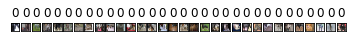

In [24]:
img, label = train_generator.next()

plt.figure(figsize = (6, 6))
for i in range(len(img)):
  plt.subplot(1, len(img), i+1)
  plt.xticks([]); plt.yticks([])
  plt.title(np.argmax(label[i]))

  plt.imshow(img[i])

In [26]:
base_model = MobileNet(weights = 'imagenet', include_top = False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

17235968/17225924 [==============================] - 0s 0us/step


In [27]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [30]:
model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.25))

model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                16400     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,245,281
Trainable params: 3,223,393
No

In [32]:
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5), metrics = ['accuracy'])

In [33]:
from datetime import datetime

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name = './cats_and_dogs_filtered_Xception_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode = 'auto')

earlystopping = EarlyStopping(monitor = 'val_loss',
                              patience = 5,)

start_time = datetime.now()

hist = model.fit(train_generator, epochs = 20,
                 validation_data = validation_generator)

end_time = datetime.now()

print('elapsed_time =>', end_time-start_time)

Epoch 1/20
50/50 [==============================] - 44s 604ms/step - loss: 0.6048 - accuracy: 0.7094 - val_loss: 0.3354 - val_accuracy: 0.8750
Epoch 2/20
50/50 [==============================] - 29s 567ms/step - loss: 0.2782 - accuracy: 0.8994 - val_loss: 0.2279 - val_accuracy: 0.9325
Epoch 3/20
50/50 [==============================] - 29s 573ms/step - loss: 0.1997 - accuracy: 0.9369 - val_loss: 0.1718 - val_accuracy: 0.9525
Epoch 4/20
50/50 [==============================] - 29s 579ms/step - loss: 0.1462 - accuracy: 0.9613 - val_loss: 0.1345 - val_accuracy: 0.9650
Epoch 5/20
50/50 [==============================] - 30s 586ms/step - loss: 0.1176 - accuracy: 0.9688 - val_loss: 0.1094 - val_accuracy: 0.9650
Epoch 6/20
50/50 [==============================] - 29s 575ms/step - loss: 0.1158 - accuracy: 0.9681 - val_loss: 0.0947 - val_accuracy: 0.9650
Epoch 7/20
50/50 [==============================] - 29s 571ms/step - loss: 0.0788 - accuracy: 0.9781 - val_loss: 0.0821 - val_accuracy: 0.9700

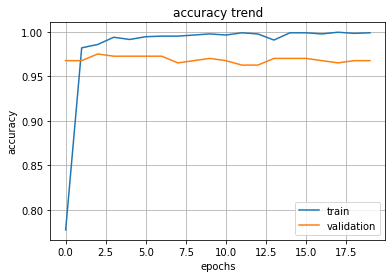

In [ ]:
import matplotlib.pyplot as plt

plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'validation')
plt.legend(loc = 'best')
plt.show()

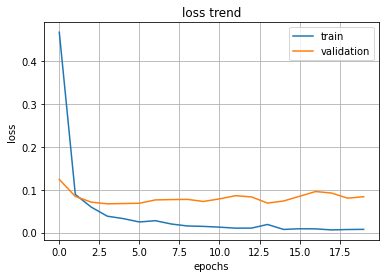

In [ ]:
plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()

In [ ]:
model.evaluate(test_generator)

63/63 [==============================] - 8s 133ms/step - loss: 0.0169 - accuracy: 0.9935


[0.016914235427975655, 0.9934999942779541]

In [ ]:
with zipfile.ZipFile('/content/test_dir.zip', 'r') as target_file:
  target_file.extractall('/content/test_dir/')

In [ ]:
import cv2
import glob

test_img_list = []

test_img_name_list = glob.glob('/content/test_dir/*')

for i in range(len(test_img_name_list)):

  src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
  src_img = cv2.resize(src_img, dsize = (IMG_WIDTH, IMG_HEIGHT))

  dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

  dst_img = dst_img / 255.0

  test_img_list.append(dst_img)

print(test_img_name_list)
print(len(test_img_list))

['/content/test_dir/test6.jpg', '/content/test_dir/test2.jpg', '/content/test_dir/test1.jpg', '/content/test_dir/test3.jpg', '/content/test_dir/test5.jpg', '/content/test_dir/test4.jpg']
6


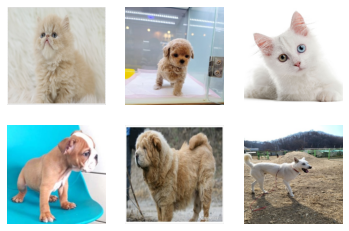

In [ ]:
plt.figure(figsize = (6, 4))

for i in range(len(test_img_list)):

  plt.subplot(2, 3, i+1)
  plt.axis('off')
  plt.imshow(test_img_list[i])

plt.show()

In [ ]:
for i in range(len(test_img_list)):
  print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [ ]:
import numpy as np

print(np.array(test_img_list).shape)

(6, 224, 224, 3)


In [ ]:
class_name = ['cat', 'dog']

pred = model.predict(np.array(test_img_list))

print(pred.shape)
print(pred)

for i in range(len(pred)):
  print(np.argmax(pred[i]))

(6, 2)
[[9.9833703e-01 1.6629288e-03]
 [2.6956119e-02 9.7304386e-01]
 [9.9991691e-01 8.3051033e-05]
 [6.5193082e-05 9.9993479e-01]
 [7.7189448e-05 9.9992275e-01]
 [1.1009237e-07 9.9999988e-01]]
0
1
0
1
1
1


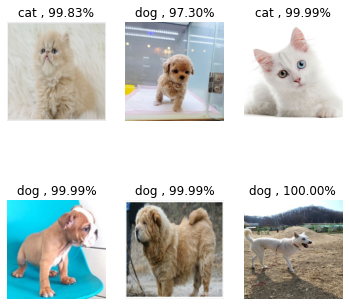

In [ ]:
class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

plt.figure(figsize=(6,6))

for i in range(len(pred)):

    plt.subplot(2, 3, i+1)
    prediction = str(class_name[np.argmax(pred[i])])
    probility = '{0:0.2f}'.format(100*max(pred[i]))
    title_str = prediction + ' , ' + probility + '%'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_list[i])

plt.show()